In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
import capo
import capo.miriad as miriad
import capo.linsolve
from scipy.sparse import csr_matrix
from tqdm import tqdm
import capo.omni as omni
from copy import deepcopy
from numpy.polynomial.legendre import legval

#import seaborn
%matplotlib notebook 

# Settings

In [2]:
pol = 'yy'
xants = [81]
dataFile = 'zen.2457678.39660.yy.HH.uvc'
firstCalFile = 'zen.2457678.39660.yy.HH.uvc.fc.npz'
calfile = 'hsa7458_v001'
minFreq, maxFreq = .108, .192
#minFreq, maxFreq = .1, .2

# Load Data and Apply FirstCal

In [3]:
meta,data,flags = miriad.read_files([dataFile],'cross',pol)
fcm,fcg,fcv,fcx = omni.from_npz(firstCalFile)
fcData = deepcopy(data)
for (ant1,ant2) in fcData.keys():
    if ant1 not in xants and ant2 not in xants:
        fcData[(ant1,ant2)][pol] /= (fcg[pol[0]][ant1] * np.conj(fcg[pol[0]][ant2]))    
freqs = meta['freqs']
nint, nchan = data.values()[0].values()[0].shape
antNames = np.sort(fcg.values()[0].keys())
aa = a.cal.get_aa(calfile, freqs)

# Omnical Data and Excise RFI

In [4]:
info = omni.aa_to_info(aa, pols=[pol[0]], ex_ants=xants, crosspols=[pol])
reds = info.get_reds()
antNames = [i for i,pos in enumerate(aa.antpos_ideal) if pos[2] != -1.0 and i not in xants]
g0 = {pol[0]: {ant: np.ones((nint,nchan),dtype=complex) for ant in antNames}}

m1, g1, v1 = omni.redcal(fcData, info, gains=g0, removedegen=True, maxiter=50)
m2, g2, v2 = omni.redcal(fcData, info, vis=v1, gains=g1, uselincal=True, removedegen=True, maxiter=50)

/Users/jsdillon/anaconda/lib/python2.7/site-packages/capo/omni.py:119: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  antpos[i,0], antpos[i,1], antpos[i,2] = x,y,z


In [5]:
xrfiFlags = capo.xrfi.omni_chisq_to_flags(m2['chisq'])
flags = (np.sum(xrfiFlags,axis=0) > 0)
flags[freqs < minFreq] = True
flags[freqs > maxFreq] = True
unflagged = np.array(1-flags,dtype=bool)

In [6]:
# plt.figure()
# #plt.plot(flags,'.')
# capo.plot.waterfall(xrfiFlags, drng=1)
# plt.figure()
# #capo.plot.waterfall(rfi, drng=1)
# plt.semilogy(m2['chisq'][-1]);
# print np.sum(xrfiFlags)#, np.sum(rfi)

# Add non-redundant baselines and reorient

In [94]:
allUniqueVis = deepcopy(v2)
redBLs = [bl for ublgroup in reds for bl in ublgroup]
for (ant1,ant2) in fcData.keys():
    if not ant1 in xants and not ant2 in xants:
        if not (ant1,ant2) in redBLs and not (ant2,ant1) in redBLs:
            allUniqueVis[pol][(ant1,ant2)] = fcData[(ant1,ant2)][pol] / g2[pol[0]][ant1] / np.conj(g2[pol[0]][ant2])

In [95]:
posDict = {antName: info.antloc[i] for i,antName in enumerate(info.subsetant)}
ublVectors = {}
for n,(ant1,ant2) in enumerate(allUniqueVis[pol].keys()):
    blVector = posDict[ant2] - posDict[ant1]
    if blVector[0] < 0 or (blVector[0]==0 and blVector[1]<0): #reorients so all BLs are +x or +y if x==0
        ublVectors[(ant2,ant1)] = -1 * blVector
        allUniqueVis[pol][(ant2,ant1)] = np.conj(allUniqueVis[pol][ant1,ant2])
        del allUniqueVis[pol][(ant1,ant2)]
    else: ublVectors[(ant1,ant2)] = blVector

# Find overlaps in the uv-plane

In [96]:
shortestBL,longestBL = [f(np.linalg.norm(ublVectors.values(),axis=1)) for f in (np.min, np.max)]
umin = shortestBL / (a.const.c/1e2) * 1e9 * freqs[0]
umax = longestBL / (a.const.c/1e2) * 1e9 * freqs[-1]
du = shortestBL / (a.const.c/1e2) * 1e9 * (freqs[1] - freqs[0]) * 5
us = np.arange(umin, umax, du)
print 'du =', du

du = 0.0237794706984


In [97]:
ublVectorsNormRound = {bl: np.round(vec / np.linalg.norm(vec),4) for bl,vec in ublVectors.items()}
orientationDict = {}
for bl,vec in ublVectorsNormRound.items():
    if orientationDict.has_key(tuple(vec)): orientationDict[tuple(vec)].append(bl)
    else: orientationDict[tuple(vec)] = [bl]
orientationGroups = [oGroup for oGroup in orientationDict.values() if len(oGroup)>=2]
#blLengthGroups = [[np.linalg.norm(ublVectors[bl]) for bl in oGroup] for oGroup in orientationDict.values() if len(oGroup)>=2]

In [105]:
equations = {}
logEqs, polyEqs, polyOrder = {}, {}, 10
legLogEqs, legendreEqs, legendreOrder = {}, {}, 10

chansWithOverlap = set([])
uBinsUsedTotal = 0
totalDataPoints = 0
for o,oGroup in enumerate(orientationGroups):
    uOccupied = np.zeros_like(us)
    for bl in oGroup:
        for chan,freq in enumerate(freqs):
            u = np.linalg.norm(ublVectors[bl]) / (a.const.c/1e2) * 1e9 * freq
            uBin = int(np.floor((u-umin)/du))
            if not flags[chan]: uOccupied[uBin] += 1
    uUsed = np.zeros_like(us)
    for bl in oGroup:
        for chan,freq in enumerate(freqs):
            u = np.linalg.norm(ublVectors[bl]) / (a.const.c/1e2) * 1e9 * freq
            uBin = int(np.floor((u-umin)/du))
            if not flags[chan] and uOccupied[uBin] >= 5: 
                #Every channel individually
                equations['bp{} * o{}u{}'.format(chan,o,uBin)] = allUniqueVis[pol][bl][:,chan]
                chansWithOverlap.add(chan)
                uUsed[uBin] += 1
                
                #Polynomial bandpass
                logEqs['bpp0 * o{}u{}'.format(o,uBin)] = allUniqueVis[pol][bl][0,chan]#[:,chan]
                polyString = ''
                for order in range(polyOrder+1): 
                    polyString += '{}*bpp{}*o{}u{}'.format((freq/.15)**order,order,o,uBin)
                    if order < polyOrder: polyString += ' + '
                polyEqs[polyString] = allUniqueVis[pol][bl][0,chan]#[:,chan]
                
                #Legendre polynomial bandpass
                legLogEqs['bplp0 * o{}u{}'.format(o,uBin)] = allUniqueVis[pol][bl][0,chan]#[:,chan]
                legendreString = ''
                for order in range(legendreOrder+1):
                    legHere = legval((freq-.15)/.05, [int(lego==order) for lego in range(legendreOrder+1)])
                    if np.abs(legHere) > 0: legendreString += '{}*bplp{}*o{}u{}'.format(legHere,order,o,uBin) 
                    if order < legendreOrder: legendreString += ' + '
                legendreEqs[legendreString] = allUniqueVis[pol][bl][0,chan]#[:,chan]
    uBinsUsedTotal += np.sum(uUsed > 0)
    totalDataPoints += np.sum(uUsed)
                
print 'total uBins to solve:',uBinsUsedTotal
print 'total chans to solve:', len(chansWithOverlap)
print 'total equations:', totalDataPoints
print np.min(freqs[list(chansWithOverlap)]), np.max(freqs[list(chansWithOverlap)]),
# plt.figure()
# plt.plot(list(chansWithOverlap),'.')
    

total uBins to solve: 525
total chans to solve: 733
total equations: 2625.0
0.108203125 0.191796875


# Direct bandpass solver

In [99]:
logSolver = capo.linsolve.LogProductSolver(equations)
logSol = logSolver.solve()
linSolver = capo.linsolve.LinProductSolver(equations, logSol)
linSol = linSolver.solve()

chansSolved = list(chansWithOverlap)
bandpassSol = np.array([linSol['bp{}'.format(chan)] for chan in chansSolved])

<IPython.core.display.Javascript object>


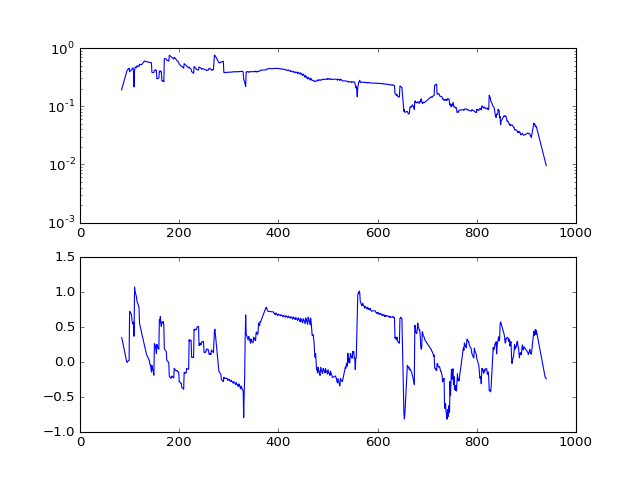

<IPython.core.display.Javascript object>


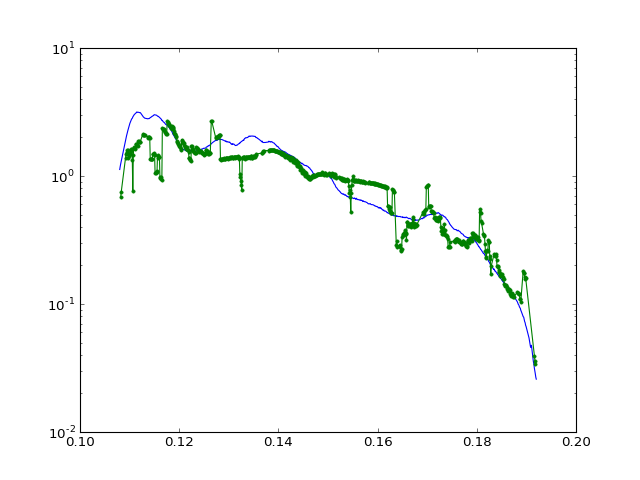

In [100]:
plt.figure()
plt.subplot(211)
plt.semilogy(chansSolved, np.abs(np.mean(bandpassSol,axis=1)))
plt.subplot(212)
plt.plot(chansSolved, np.angle(np.mean(bandpassSol,axis=1)))

plt.figure()
meanVis = np.mean(np.abs([allUniqueVis['yy'][bl][:,unflagged] for bl in allUniqueVis['yy'].keys()]), axis=(0,1))
plt.semilogy(freqs[unflagged], meanVis / np.median(meanVis))
plt.semilogy(freqs[chansSolved], np.abs(np.mean(bandpassSol,axis=1)) / np.median(np.abs(np.mean(bandpassSol,axis=1))),'.-')
#plt.semilogy(freqs, np.abs(bandpass3) / np.mean(np.abs(bandpass3[chansSolved])),'.-')

# Polynomial bandpass

In [106]:
# %cd /Users/jsdillon/Desktop/capo
# ! python setup.py install >/dev/null
# %cd /Users/jsdillon/Desktop/capo/jsd/
# uc = reload(capo.linsolve)

polyLogSolver = capo.linsolve.LogProductSolver(logEqs)
polyLogSol = polyLogSolver.solve()
for order in range(1,polyOrder+1): polyLogSol['bpp{}'.format(order)] = 0.0+0.0j
    
polyLinSolver = capo.linsolve.LinProductSolver(polyEqs, polyLogSol)
polyLinSol = polyLinSolver.solve()
polyLinSolver = capo.linsolve.LinProductSolver(polyEqs, polyLinSol)
polyLinSol2 = polyLinSolver.solve()
polyLinSolver = capo.linsolve.LinProductSolver(polyEqs, polyLinSol2)
polyLinSol3 = polyLinSolver.solve()


<IPython.core.display.Javascript object>


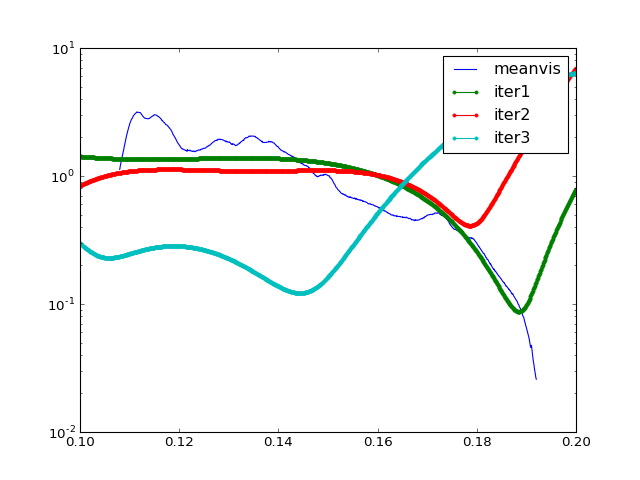

<IPython.core.display.Javascript object>


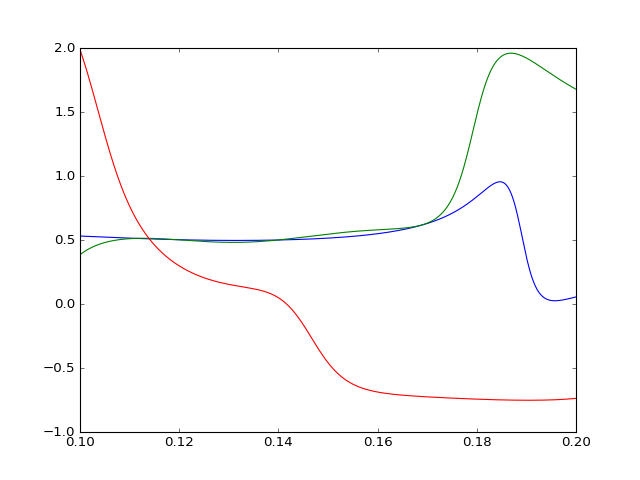

In [107]:
#print np.sort(polyLogSol.keys())
bandpassPoly = np.array([polyLinSol['bpp{}'.format(order)] for order in range(polyOrder,-1,-1)])
bandpass = np.polyval(bandpassPoly,(freqs/.15))

bandpassPoly2 = np.array([polyLinSol2['bpp{}'.format(order)] for order in range(polyOrder,-1,-1)])
bandpass2 = np.polyval(bandpassPoly2,(freqs/.15))

bandpassPoly3 = np.array([polyLinSol3['bpp{}'.format(order)] for order in range(polyOrder,-1,-1)])
bandpass3 = np.polyval(bandpassPoly3,(freqs/.15))


meanVis = np.mean(np.abs([allUniqueVis['yy'][bl][:,unflagged] for bl in allUniqueVis['yy'].keys()]), axis=(0,1))

plt.figure()
plt.semilogy(freqs[unflagged], meanVis / np.median(meanVis))
plt.semilogy(freqs, np.abs(bandpass) / np.mean(np.abs(bandpass[unflagged])),'.-')
plt.semilogy(freqs, np.abs(bandpass2) / np.mean(np.abs(bandpass2[unflagged])),'.-')
plt.semilogy(freqs, np.abs(bandpass3) / np.mean(np.abs(bandpass3[unflagged])),'.-')
plt.legend(['meanvis','iter1', 'iter2', 'iter3'])

plt.figure()
plt.plot(freqs, np.unwrap(np.angle(bandpass)))
plt.plot(freqs, np.unwrap(np.angle(bandpass2)))
plt.plot(freqs, np.unwrap(np.angle(bandpass3)))


# Legendre Polynomial Bandpass

In [108]:
legendreLogSolver = capo.linsolve.LogProductSolver(legLogEqs)
legendreLogSol = legendreLogSolver.solve()
for order in range(1,legendreOrder+1): legendreLogSol['bplp{}'.format(order)] = 0.0+0.0j


legendreLinSolver = capo.linsolve.LinProductSolver(legendreEqs, legendreLogSol)
legendreLinSol = legendreLinSolver.solve()
legendreLinSolver2 = capo.linsolve.LinProductSolver(legendreEqs, legendreLinSol)
legendreLinSol2 = legendreLinSolver2.solve()
legendreLinSolver3 = capo.linsolve.LinProductSolver(legendreEqs, legendreLinSol2)
legendreLinSol3 = legendreLinSolver3.solve()

<IPython.core.display.Javascript object>


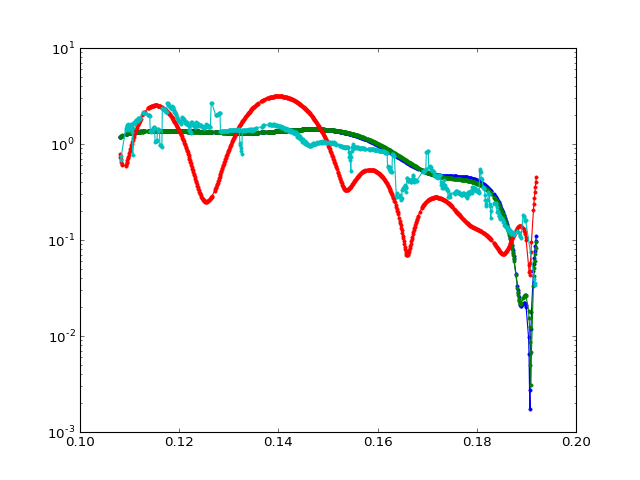

<IPython.core.display.Javascript object>


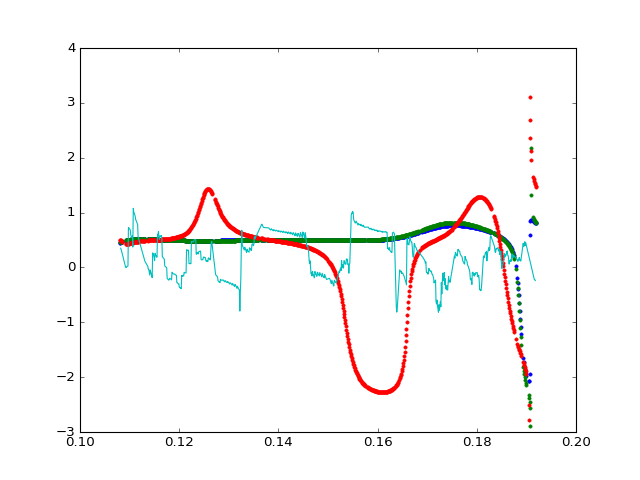

In [109]:
legCoeffs = np.array([legendreLinSol['bplp{}'.format(order)] for order in range(0,legendreOrder+1)])
legBandpass = legval((freqs-.15)/.05, legCoeffs)
legCoeffs2 = np.array([legendreLinSol2['bplp{}'.format(order)] for order in range(0,legendreOrder+1)])
legBandpass2 = legval((freqs-.15)/.05, legCoeffs2)
legCoeffs3 = np.array([legendreLinSol3['bplp{}'.format(order)] for order in range(0,legendreOrder+1)])
legBandpass3 = legval((freqs-.15)/.05, legCoeffs3)



plt.figure()
plt.semilogy(freqs[unflagged], np.abs(legBandpass[unflagged]) / np.mean(np.abs(legBandpass[unflagged])),'.-')
plt.semilogy(freqs[unflagged], np.abs(legBandpass2[unflagged]) / np.mean(np.abs(legBandpass2[unflagged])),'.-')
plt.semilogy(freqs[unflagged], np.abs(legBandpass3[unflagged]) / np.mean(np.abs(legBandpass3[unflagged])),'.-')
plt.semilogy(freqs[chansSolved], np.abs(np.mean(bandpassSol,axis=1)) / np.median(np.abs(np.mean(bandpassSol,axis=1))),'.-')
meanVis = np.mean(np.abs([allUniqueVis['yy'][bl][:,unflagged] for bl in allUniqueVis['yy'].keys()]), axis=(0,1))
#plt.semilogy(freqs[unflagged], meanVis / np.median(meanVis))

plt.figure()
plt.plot(freqs[unflagged], np.angle(legBandpass[unflagged]),'.')
plt.plot(freqs[unflagged], np.angle(legBandpass2[unflagged]),'.')
plt.plot(freqs[unflagged], np.angle(legBandpass3[unflagged]),'.')
plt.plot(freqs[chansSolved], np.angle(np.mean(bandpassSol,axis=1)))


In [110]:
# #A = logSolver.ls_phs.get_A()
# A = linSolver.ls.get_A()
# AtA = A[...,0].T.dot(A[...,0])
# U,S,V = np.linalg.svd(AtA)
# plt.figure()
# plt.semilogy(S)


In [111]:
#TODO: refactor as a 10th order polynomial or whatever
#TODO: also, see what we can learn about the phase gradient

TODO: try legendre polynomials

~~TODO: try multiple iterations of linsolve until it converges~~ This helps, but not a ton.

<IPython.core.display.Javascript object>


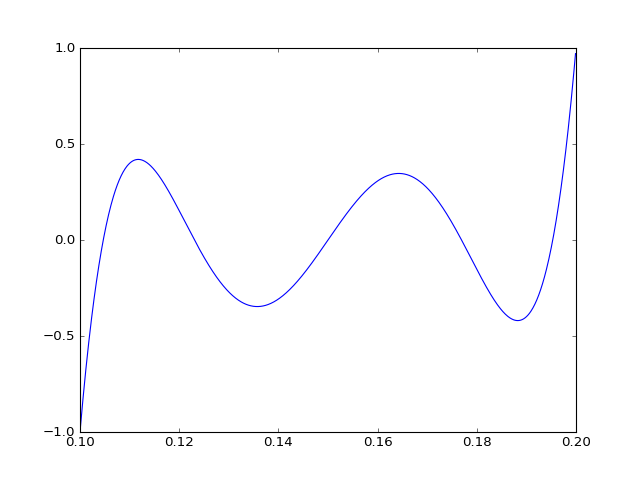

In [112]:

plt.figure()
plt.plot(freqs, legval((freqs-.15)/.05,[0,0,0,0,0,1]))